# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


## Business Case
Based on User data, Offer data and data related to user's interaction with offers, I will try to predict user behaviour. More specifically, I will try to predict how well users respond to the offers received by them.

## Project Description

First I will study the data using various visualization techniques and then I will use:

1) Supervised Machine Learning to try to predict the amount to be spent in Starbucks by the customer so that decision-makers can identify users on whom the offer works and can focus their efforts on those users.

2) Supervised Machine Learning to classify users based on the type of spenders ("high", "medium" or "low") and making offers based on that classification.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
portfolio.head()

reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   

                                 id  
0  ae264e3637204a6fb9bb56bc8210ddfd  
1  4d5c57ea9a6940dd891ad53e9dbe8da0  
2  3f207df678b143eea3cee63160fa8bed  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7

In [3]:
profile.head()

gender  age                                id  became_member_on    income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0
2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712       NaN
3      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0
4   None  118  a03223e636434f42ac4c3df47e8bac43          20170804       NaN

In [4]:
transcript.head()

person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0

In [5]:
#extracting only transactions done by the user

transaction = transcript[transcript.event=="transaction"]

transaction.head()

person        event  \
12654  02c083884c7d45b39cc68e1314fec56c  transaction   
12657  9fa9ae8f57894cc9a3b8a9bbe0fc1b2f  transaction   
12659  54890f68699049c2a04d415abc25e717  transaction   
12670  b2f1cd155b864803ad8334cdf13c4bd2  transaction   
12671  fe97aa22dd3e48c8b143116a8403dd52  transaction   

                                value  time  
12654  {'amount': 0.8300000000000001}     0  
12657               {'amount': 34.56}     0  
12659               {'amount': 13.23}     0  
12670               {'amount': 19.51}     0  
12671               {'amount': 18.97}     0

In [6]:
#Splitting the str to columns

temp = transaction.value.astype(str).str.split("{'amount': ", 1, expand=True)
temp.columns = ['temp', 'amount']
temp[['amount', 'temp2']] = temp.amount.astype(str).str.split("}", 1, expand=True)
temp = temp.drop(['temp', 'temp2'], axis=1)
temp = temp.astype('float64')

transaction = pd.concat([transaction, temp], axis=1)

In [7]:
transaction.head()

person        event  \
12654  02c083884c7d45b39cc68e1314fec56c  transaction   
12657  9fa9ae8f57894cc9a3b8a9bbe0fc1b2f  transaction   
12659  54890f68699049c2a04d415abc25e717  transaction   
12670  b2f1cd155b864803ad8334cdf13c4bd2  transaction   
12671  fe97aa22dd3e48c8b143116a8403dd52  transaction   

                                value  time  amount  
12654  {'amount': 0.8300000000000001}     0    0.83  
12657               {'amount': 34.56}     0   34.56  
12659               {'amount': 13.23}     0   13.23  
12670               {'amount': 19.51}     0   19.51  
12671               {'amount': 18.97}     0   18.97

#### Cleaning the Data

We shall now clean the data to remove any NaN values


In [8]:
print("Percentage of NaN Values are:", profile.income.isna().sum() / profile.income.count() * 100)

Percentage of NaN Values are: 14.67116357504216


In [9]:
# filling NaN values
profile.income = profile.income.fillna(0)
profile.head()

gender  age                                id  became_member_on    income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       0.0
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0
2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712       0.0
3      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0
4   None  118  a03223e636434f42ac4c3df47e8bac43          20170804       0.0

In [10]:
set(profile.gender)

{'F', 'M', None, 'O'}

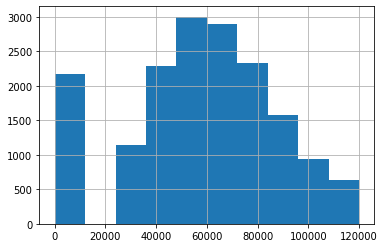

In [11]:
profile.income.hist();

Cleaning the offer data

In [12]:
def clean_data(df, string):
    """
    Takes transcript dataframe and returns cleaned offer_id dataframe
    
    Inputs 
    df: pd.DataFrame
    string: str, event which needs to be cleaned
    
    Outputs
    cleaned_df: pd.DataFrame
    """
    temp = df[df.event==string].value.astype(str).str.split("{'offer id': ", 1, expand=True)
    temp.columns = ['temp', 'offer_id']
    temp[['offer_id', 'temp2']] = temp.offer_id.astype(str).str.split("}", 1, expand=True)
    temp = temp.drop(['temp', 'temp2'], axis=1)
    clean_df = pd.concat([df[df.event==string], temp], axis=1)
    return clean_df

In [13]:
offer_received = clean_data(transcript, "offer received")
offer_received = offer_received.drop(['event', 'value'], axis=1)
offer_received.head()

person  time                            offer_id
0  78afa995795e4d85b5d9ceeca43f5fef     0  '9b98b8c7a33c4b65b9aebfe6a799e6d9'
1  a03223e636434f42ac4c3df47e8bac43     0  '0b1e1539f2cc45b7b9fa7c272da2e1d7'
2  e2127556f4f64592b11af22de27a7932     0  '2906b810c7d4411798c6938adc9daaa5'
3  8ec6ce2a7e7949b1bf142def7d0e0586     0  'fafdcd668e3743c1bb461111dcafc2a4'
4  68617ca6246f4fbc85e91a2a49552598     0  '4d5c57ea9a6940dd891ad53e9dbe8da0'

In [14]:
# Cleaning offer completed data
temp = transcript[transcript.event=="offer completed"].value.astype(str).str.split("{'offer_id': ", 1, expand=True)
temp.columns = ['temp', 'offer_id']
temp[['offer_id', 'temp2']] = temp.offer_id.astype(str).str.split(",", 1, expand=True)
temp[['temp3', 'reward']] = temp.temp2.astype(str).str.split("'reward': ", 1, expand=True)
temp[['reward', 'temp4']] = temp.reward.astype(str).str.split("}", 1, expand=True)
temp = temp.drop(['temp', 'temp2', 'temp3', 'temp4'], axis=1)
offer_completed = pd.concat([transcript[transcript.event=="offer completed"], temp], axis=1)

In [15]:
offer_completed = offer_completed.drop(['event', 'value'], axis=1)
offer_completed['reward'] = offer_completed.reward.astype('float64')
offer_completed.head()

person  time  \
12658  9fa9ae8f57894cc9a3b8a9bbe0fc1b2f     0   
12672  fe97aa22dd3e48c8b143116a8403dd52     0   
12679  629fc02d56414d91bca360decdfa9288     0   
12692  676506bad68e4161b9bbaffeb039626b     0   
12697  8f7dd3b2afe14c078eb4f6e6fe4ba97d     0   

                                 offer_id  reward  
12658  '2906b810c7d4411798c6938adc9daaa5'     2.0  
12672  'fafdcd668e3743c1bb461111dcafc2a4'     2.0  
12679  '9b98b8c7a33c4b65b9aebfe6a799e6d9'     5.0  
12692  'ae264e3637204a6fb9bb56bc8210ddfd'    10.0  
12697  '4d5c57ea9a6940dd891ad53e9dbe8da0'    10.0

In [16]:
# Combining the offer data
com_offer_com_temp1 = pd.pivot_table(offer_completed, values='reward', index=['person'],
                                    aggfunc=np.mean)
com_offer_com_temp2 = pd.pivot_table(offer_completed, values='offer_id', index=['person'],
                                    aggfunc=np.count_nonzero)
com_offer_completed = pd.concat([com_offer_com_temp1, com_offer_com_temp2], axis=1)
com_offer_completed = com_offer_completed.reset_index()
com_offer_completed.columns = ['id','avg_reward','offers_done']
com_offer_completed.head()

id  avg_reward  offers_done
0  0009655768c64bdeb2e877511632db8f    3.000000            3
1  0011e0d4e6b944f998e987f904e8c1e5    4.333333            3
2  0020c2b971eb4e9188eac86d93036a77    4.666667            3
3  0020ccbbb6d84e358d3414a3ff76cffd    4.333333            3
4  003d66b6608740288d6cc97a6903f4f0    3.000000            3

In [17]:
com_offer_rec = pd.pivot_table(offer_received, values='offer_id', index=['person'],
                                    aggfunc=np.count_nonzero)
com_offer_rec = com_offer_rec.reset_index()
com_offer_rec.columns = ['id','offers_rcv']
com_offer_rec.head()

id  offers_rcv
0  0009655768c64bdeb2e877511632db8f           5
1  00116118485d4dfda04fdbaba9a87b5c           2
2  0011e0d4e6b944f998e987f904e8c1e5           5
3  0020c2b971eb4e9188eac86d93036a77           5
4  0020ccbbb6d84e358d3414a3ff76cffd           4

In [18]:
#Combining the transaction data
com_tran_temp1 = pd.pivot_table(transaction, values='amount', index=['person'], 
                         aggfunc=np.sum)
com_tran_temp2 = pd.pivot_table(transaction, values='amount', index=['person'], 
                         aggfunc=np.count_nonzero)
com_tran_temp2.columns = ['count']
com_tran = pd.concat([com_tran_temp1, com_tran_temp2], axis=1)
com_tran = com_tran.reset_index()
com_tran

person  amount  count
0      0009655768c64bdeb2e877511632db8f  127.60    8.0
1      00116118485d4dfda04fdbaba9a87b5c    4.09    3.0
2      0011e0d4e6b944f998e987f904e8c1e5   79.46    5.0
3      0020c2b971eb4e9188eac86d93036a77  196.86    8.0
4      0020ccbbb6d84e358d3414a3ff76cffd  154.05   12.0
...                                 ...     ...    ...
16573  fff3ba4757bd42088c044ca26d73817a  580.98   11.0
16574  fff7576017104bcc8677a8d63322b5e1   29.94    6.0
16575  fff8957ea8b240a6b5e634b6ee8eafcf   12.15    5.0
16576  fffad4f4828548d1b5583907f2e9906b   88.83   12.0
16577  ffff82501cea40309d5fdd7edcca4a07  226.07   15.0

[16578 rows x 3 columns]

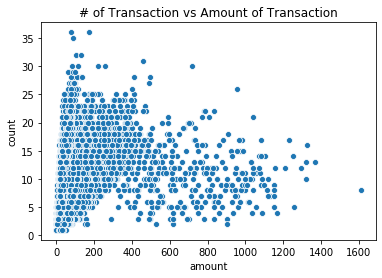

In [19]:
sn.scatterplot(com_tran['amount'], com_tran['count']).set_title('# of Transaction vs Amount of Transaction');

#### Combining all of the cleaned Data

We shall now combine the data for cluster analysis

In [20]:
com_tran.columns = ['id', 'amount', 'count']
com_tran.head()

id  amount  count
0  0009655768c64bdeb2e877511632db8f  127.60    8.0
1  00116118485d4dfda04fdbaba9a87b5c    4.09    3.0
2  0011e0d4e6b944f998e987f904e8c1e5   79.46    5.0
3  0020c2b971eb4e9188eac86d93036a77  196.86    8.0
4  0020ccbbb6d84e358d3414a3ff76cffd  154.05   12.0

In [21]:
comb_df = pd.merge(profile, com_tran, on='id')
comb_df = pd.merge(comb_df, com_offer_rec, on='id')
comb_df = pd.merge(comb_df, com_offer_completed, on='id')
comb_df.head()

gender  age                                id  became_member_on    income  \
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       0.0   
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0   
2      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0   
3      M   68  e2127556f4f64592b11af22de27a7932          20180426   70000.0   
4      M   65  389bc3fa690240e798340f5a15918d5c          20180209   53000.0   

   amount  count  offers_rcv  avg_reward  offers_done  
0   20.40    9.0           5    2.500000            2  
1   77.01    3.0           2    5.000000            1  
2  159.27    7.0           4    6.666667            3  
3   57.73    3.0           4    3.500000            2  
4   36.43    3.0           6    3.800000            5

In [22]:
#add a column to compute total offers_completed
comb_df['perc_comp'] = comb_df['offers_done']/comb_df['offers_rcv']
comb_df.head()

gender  age                                id  became_member_on    income  \
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       0.0   
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0   
2      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0   
3      M   68  e2127556f4f64592b11af22de27a7932          20180426   70000.0   
4      M   65  389bc3fa690240e798340f5a15918d5c          20180209   53000.0   

   amount  count  offers_rcv  avg_reward  offers_done  perc_comp  
0   20.40    9.0           5    2.500000            2   0.400000  
1   77.01    3.0           2    5.000000            1   0.500000  
2  159.27    7.0           4    6.666667            3   0.750000  
3   57.73    3.0           4    3.500000            2   0.500000  
4   36.43    3.0           6    3.800000            5   0.833333

#### Visualize the dataframe


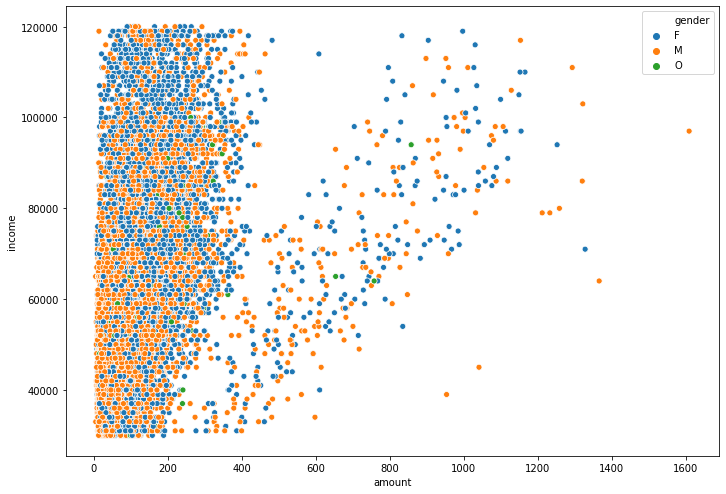

In [23]:
#User spend behaviour
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sn.scatterplot(comb_df['amount'], comb_df['income'], hue=comb_df['gender']);

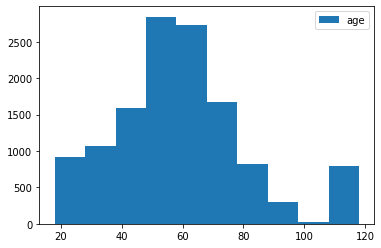

In [24]:
plt.hist(comb_df['age']);
plt.legend(['age']);

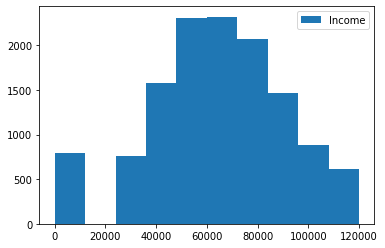

In [25]:
plt.hist(comb_df['income']);
plt.legend(["Income"]);

There are no users who income below 25000 which is strange. But this is not a outlier.

#### Removing outliers

As we can see in the above histogram, there are around 2000 users whose age is more than 100. Looks like error in data and we will drop the users with age more than 100.

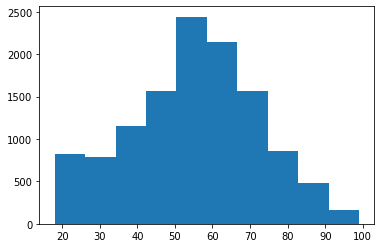

In [26]:
clean_df = comb_df[comb_df['age']<100]
plt.hist(clean_df['age']);

In [27]:
clean_df.head()

gender  age                                id  became_member_on    income  \
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0   
2      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0   
3      M   68  e2127556f4f64592b11af22de27a7932          20180426   70000.0   
4      M   65  389bc3fa690240e798340f5a15918d5c          20180209   53000.0   
8      M   58  2eeac8d8feae4a8cad5a6af0499a211d          20171111   51000.0   

   amount  count  offers_rcv  avg_reward  offers_done  perc_comp  
1   77.01    3.0           2    5.000000            1   0.500000  
2  159.27    7.0           4    6.666667            3   0.750000  
3   57.73    3.0           4    3.500000            2   0.500000  
4   36.43    3.0           6    3.800000            5   0.833333  
8   15.62    4.0           3    2.000000            1   0.333333

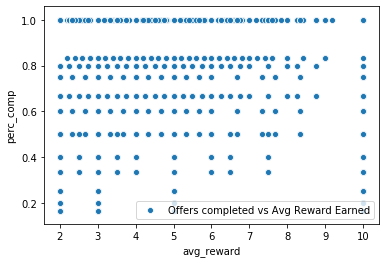

In [28]:
sn.scatterplot(clean_df['avg_reward'], clean_df['perc_comp']);
plt.legend(["Offers completed vs Avg Reward Earned"]);

In [29]:
clean_df['spend_pctg'] = clean_df['amount']/clean_df['income']
clean_df.head()

/Users/zainfarrukh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


gender  age                                id  became_member_on    income  \
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0   
2      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0   
3      M   68  e2127556f4f64592b11af22de27a7932          20180426   70000.0   
4      M   65  389bc3fa690240e798340f5a15918d5c          20180209   53000.0   
8      M   58  2eeac8d8feae4a8cad5a6af0499a211d          20171111   51000.0   

   amount  count  offers_rcv  avg_reward  offers_done  perc_comp  spend_pctg  
1   77.01    3.0           2    5.000000            1   0.500000    0.000688  
2  159.27    7.0           4    6.666667            3   0.750000    0.001593  
3   57.73    3.0           4    3.500000            2   0.500000    0.000825  
4   36.43    3.0           6    3.800000            5   0.833333    0.000687  
8   15.62    4.0           3    2.000000            1   0.333333    0.000306

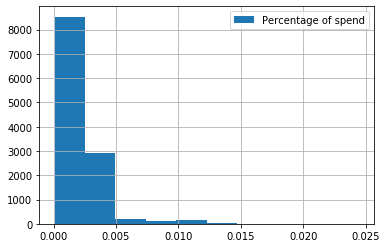

In [30]:
clean_df['spend_pctg'].hist();
plt.legend(["Percentage of spend"]);

In [31]:
def label_func(df):
    """
    Function to label users based on how much they spend on starbucks in relation to their income.
    Anyone spending 5% or more of their total income will be classified as high spenders; 2.5% medium and remaining low
    
    Inputs
    ------
    df: DataFrame containing user data
    
    Returns
    ------
    df: Same DataFrame with spend label
    
    """
    df['spend_label'] = np.zeros
    for i in range(len(df)):
        if df['spend_pctg'].iloc[i] >= 0.005: 
            df['spend_label'].iloc[i] = "high"
        elif df['spend_pctg'].iloc[i] >= 0.0025:
            df['spend_label'].iloc[i] = "medium"
        else:
            df['spend_label'].iloc[i] = "low"
    return df
clean_df = label_func(clean_df)
clean_df.head()

/Users/zainfarrukh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/Users/zainfarrukh/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/zainfarrukh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: h

gender  age                                id  became_member_on    income  \
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0   
2      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0   
3      M   68  e2127556f4f64592b11af22de27a7932          20180426   70000.0   
4      M   65  389bc3fa690240e798340f5a15918d5c          20180209   53000.0   
8      M   58  2eeac8d8feae4a8cad5a6af0499a211d          20171111   51000.0   

   amount  count  offers_rcv  avg_reward  offers_done  perc_comp  spend_pctg  \
1   77.01    3.0           2    5.000000            1   0.500000    0.000688   
2  159.27    7.0           4    6.666667            3   0.750000    0.001593   
3   57.73    3.0           4    3.500000            2   0.500000    0.000825   
4   36.43    3.0           6    3.800000            5   0.833333    0.000687   
8   15.62    4.0           3    2.000000            1   0.333333    0.000306   

  spend_label  
1         low  
2         low  
3         low  
4         low  
8         low

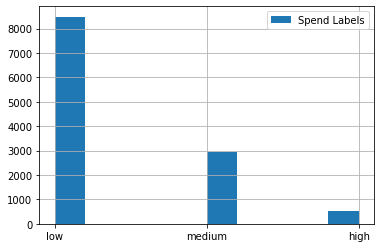

In [32]:
clean_df['spend_label'].hist();
plt.legend(['Spend Labels']);

In [33]:
clean_df['spend_label'][clean_df['spend_label']=="high"].count()

526

There are 526 high spend users and we can focus our efforts on those users for future offers to stimulate sales

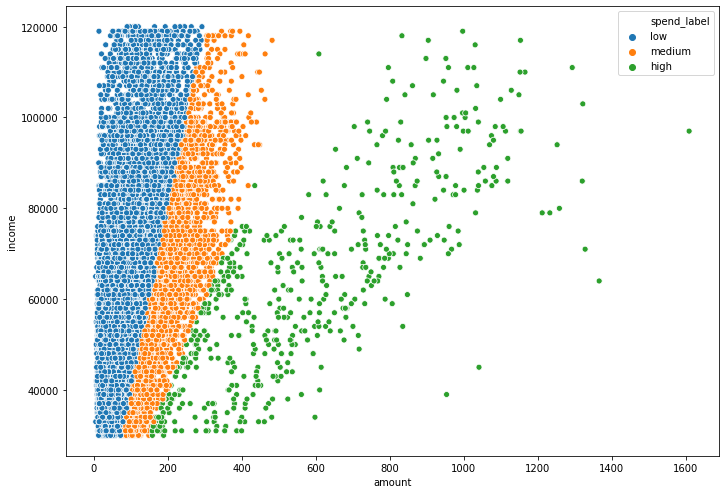

In [34]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sn.scatterplot(clean_df['amount'], clean_df['income'], hue=clean_df['spend_label']);

In [35]:
#Extracting year of membership
clean_df['date'] = pd.to_datetime(clean_df['became_member_on'], format = '%Y%m%d', errors = 'coerce')
clean_df.head()

/Users/zainfarrukh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


gender  age                                id  became_member_on    income  \
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0   
2      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0   
3      M   68  e2127556f4f64592b11af22de27a7932          20180426   70000.0   
4      M   65  389bc3fa690240e798340f5a15918d5c          20180209   53000.0   
8      M   58  2eeac8d8feae4a8cad5a6af0499a211d          20171111   51000.0   

   amount  count  offers_rcv  avg_reward  offers_done  perc_comp  spend_pctg  \
1   77.01    3.0           2    5.000000            1   0.500000    0.000688   
2  159.27    7.0           4    6.666667            3   0.750000    0.001593   
3   57.73    3.0           4    3.500000            2   0.500000    0.000825   
4   36.43    3.0           6    3.800000            5   0.833333    0.000687   
8   15.62    4.0           3    2.000000            1   0.333333    0.000306   

  spend_label       date  
1         low 2017-07-15  
2         low 2017-05-09  
3         low 2018-04-26  
4         low 2018-02-09  
8         low 2017-11-11

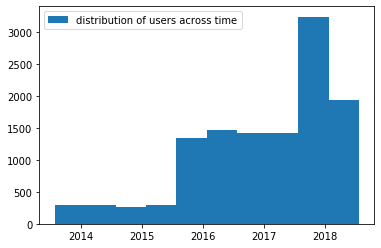

In [36]:
plt.hist(clean_df['date']);
plt.legend(['distribution of users across time']);

In [37]:
clean_df['year'] = clean_df['date'].dt.year
clean_df.head()

/Users/zainfarrukh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


gender  age                                id  became_member_on    income  \
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0   
2      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0   
3      M   68  e2127556f4f64592b11af22de27a7932          20180426   70000.0   
4      M   65  389bc3fa690240e798340f5a15918d5c          20180209   53000.0   
8      M   58  2eeac8d8feae4a8cad5a6af0499a211d          20171111   51000.0   

   amount  count  offers_rcv  avg_reward  offers_done  perc_comp  spend_pctg  \
1   77.01    3.0           2    5.000000            1   0.500000    0.000688   
2  159.27    7.0           4    6.666667            3   0.750000    0.001593   
3   57.73    3.0           4    3.500000            2   0.500000    0.000825   
4   36.43    3.0           6    3.800000            5   0.833333    0.000687   
8   15.62    4.0           3    2.000000            1   0.333333    0.000306   

  spend_label       date  year  
1         low 2017-07-15  2017  
2         low 2017-05-09  2017  
3         low 2018-04-26  2018  
4         low 2018-02-09  2018  
8         low 2017-11-11  2017

##### Creating Dummy Variables
We shall now create dummy variable so that we can use categorical variable in our ML models

In [38]:
# Dummy variable for gender
dummy = pd.get_dummies(clean_df['gender'])
clean_df = pd.concat([clean_df,dummy], axis=1)
clean_df = clean_df.drop('gender', axis=1)
clean_df.head()

age                                id  became_member_on    income  amount  \
1   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0   77.01   
2   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0  159.27   
3   68  e2127556f4f64592b11af22de27a7932          20180426   70000.0   57.73   
4   65  389bc3fa690240e798340f5a15918d5c          20180209   53000.0   36.43   
8   58  2eeac8d8feae4a8cad5a6af0499a211d          20171111   51000.0   15.62   

   count  offers_rcv  avg_reward  offers_done  perc_comp  spend_pctg  \
1    3.0           2    5.000000            1   0.500000    0.000688   
2    7.0           4    6.666667            3   0.750000    0.001593   
3    3.0           4    3.500000            2   0.500000    0.000825   
4    3.0           6    3.800000            5   0.833333    0.000687   
8    4.0           3    2.000000            1   0.333333    0.000306   

  spend_label       date  year  F  M  O  
1         low 2017-07-15  2017  1  0  0  
2         low 2017-05-09  2017  1  0  0  
3         low 2018-04-26  2018  0  1  0  
4         low 2018-02-09  2018  0  1  0  
8         low 2017-11-11  2017  0  1  0

In [39]:
# Creating dummy variable for year
dummy = pd.get_dummies(clean_df['year'])
clean_df = pd.concat([clean_df,dummy], axis=1)
clean_df = clean_df.drop('year', axis=1)
clean_df.head()

age                                id  became_member_on    income  amount  \
1   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0   77.01   
2   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0  159.27   
3   68  e2127556f4f64592b11af22de27a7932          20180426   70000.0   57.73   
4   65  389bc3fa690240e798340f5a15918d5c          20180209   53000.0   36.43   
8   58  2eeac8d8feae4a8cad5a6af0499a211d          20171111   51000.0   15.62   

   count  offers_rcv  avg_reward  offers_done  perc_comp  ...       date  F  \
1    3.0           2    5.000000            1   0.500000  ... 2017-07-15  1   
2    7.0           4    6.666667            3   0.750000  ... 2017-05-09  1   
3    3.0           4    3.500000            2   0.500000  ... 2018-04-26  0   
4    3.0           6    3.800000            5   0.833333  ... 2018-02-09  0   
8    4.0           3    2.000000            1   0.333333  ... 2017-11-11  0   

   M  O  2013  2014  2015  2016  2017  2018  
1  0  0     0     0     0     0     1     0  
2  0  0     0     0     0     0     1     0  
3  1  0     0     0     0     0     0     1  
4  1  0     0     0     0     0     0     1  
8  1  0     0     0     0     0     1     0  

[5 rows x 22 columns]

#### Feature Correlation

We shall now check the feature correlation

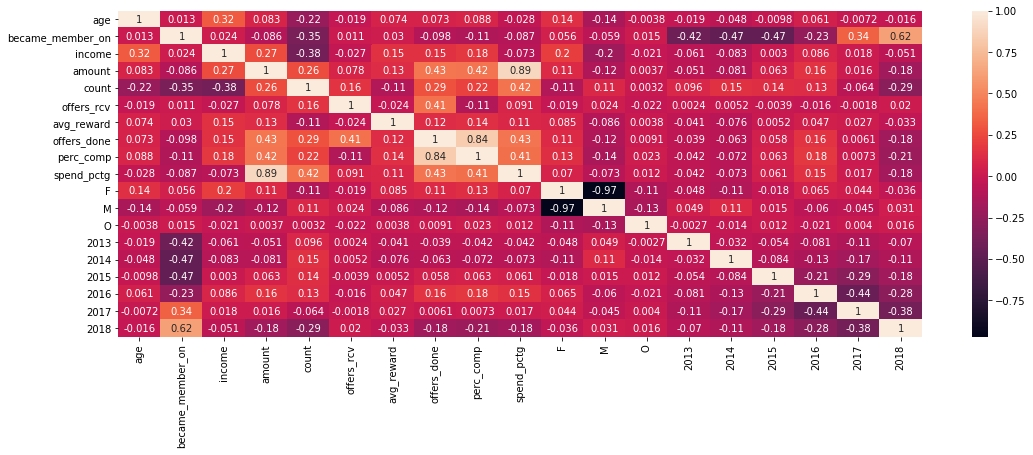

In [40]:
fig, ax = plt.subplots(figsize=(18,6))
sn.heatmap(clean_df.corr(), annot = True, ax=ax)
plt.show()

Correlation among features are somehow expected. For example, there is strong correlation between offers done and percentage of offer completed.

### Supervised Machine Learning to predict amount to be spent in Starbucks, average reward on offers and percentage of offers completed
Now we shall use ML to predict three variables i.e. amount spent, average reward and probability user will complete an offer

#### We will use Support Vector Machines to predict our three variables

In [41]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.metrics import classification_report

In [42]:
X = np.array(clean_df.drop(['id', 'became_member_on', 'amount','count','spend_pctg', 'spend_label'
                           , 'date'], axis=1)) #Drop the irrelevant columns

y1 = clean_df['amount']
#y2 = clean_df['avg_reward']
#y3 = clean_df['perc_comp']

In [43]:
X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.50, random_state=42)

In [44]:
regr1 = make_pipeline(StandardScaler(), SVR(C=5.0, epsilon=0.1))
regr1.fit(X_train, y1_train)
y1_hat = regr1.predict(X_test)

In [45]:
#regr2 = make_pipeline(StandardScaler(), SVR(C=5.0, epsilon=0.1))
#regr2.fit(X_train, y2_train)
#y2_hat = regr2.predict(X_test)

In [46]:
#regr3 = make_pipeline(StandardScaler(), SVR(C=5.0, epsilon=0.1))
#regr3.fit(X_train, y3_train)
#y3_hat = regr3.predict(X_test)

In [47]:
print("Train R2-Score: {0}, Test R2-Score: {1}"
      .format(regr1.score(X_train, y1_train), regr1.score(X_test, y1_test)))
#print("Train R2-Score: {0}, Test R2-Score: {1}"
      #.format(regr2.score(X_train, y2_train), regr2.score(X_test, y2_test)))
#print("Train R2-Score: {0}, Test R2-Score: {1}"
      #.format(regr3.score(X_train, y3_train), regr3.score(X_test, y3_test)))


Train R2-Score: 0.21584996940738865, Test R2-Score: 0.22046198108552184


#### Random Forrest Classifier to preedict whether user is high spender or low spender
Now we shall use Random Forrest model to predict whether a particular user would be high spender or low

In [48]:
y_class = clean_df['spend_label']
y_class

1           low
2           low
3           low
4           low
8           low
          ...  
12769    medium
12770       low
12771       low
12772    medium
12773       low
Name: spend_label, Length: 11969, dtype: object

In [49]:
X_train, X_test, y_class_train, y_class_test = train_test_split(X, y_class, test_size=0.50, random_state=42)

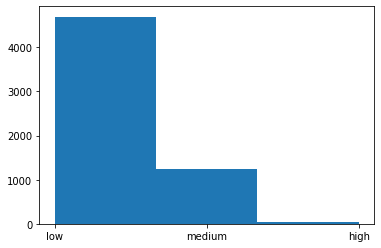

In [50]:
classifier = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=30, random_state=0))
classifier.fit(X_train, y_class_train)

y_pred_1 = classifier.predict(X_test)
plt.hist(y_pred_1, bins=3);

Accuracy score of the model is:  0.7340016708437761


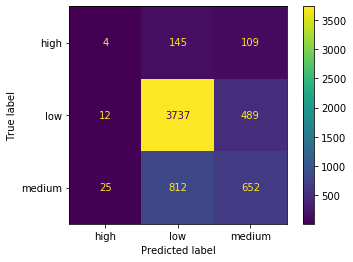

In [51]:
print ("Accuracy score of the model is: ", accuracy_score(y_class_test, y_pred_1))
plot_confusion_matrix(classifier, X_test, y_class_test, values_format="d");

In [52]:
print(classification_report(y_class_test, y_pred_1))

              precision    recall  f1-score   support

        high       0.10      0.02      0.03       258
         low       0.80      0.88      0.84      4238
      medium       0.52      0.44      0.48      1489

    accuracy                           0.73      5985
   macro avg       0.47      0.45      0.45      5985
weighted avg       0.70      0.73      0.71      5985



#### Tuning Hyperparameters

We can now tune some hyperparameters of Random Forrest Classifier to see whether we can increase the accuracy

In [53]:
accuracy ={}
for i in range(1,200):
    classifier = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=i, random_state=15))
    classifier.fit(X_train, y_class_train)
    y_pred_ev = classifier.predict(X_test)
    accuracy[i] = accuracy_score(y_class_test, y_pred_ev)

In [54]:
max(accuracy.values())

0.740016708437761

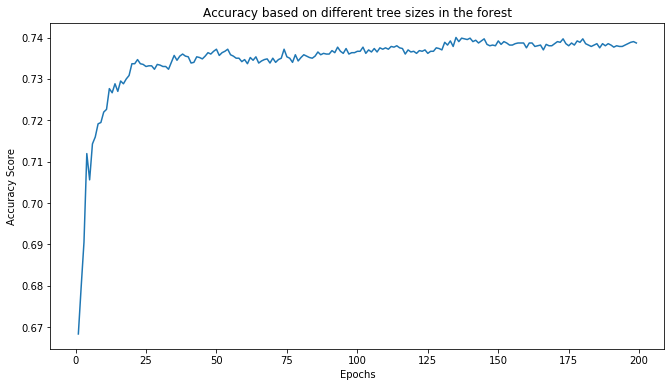

In [55]:
plt.figure(figsize=(11 , 6))
plt.plot(list(accuracy.keys()), list(accuracy.values()))
plt.title('Accuracy based on different tree sizes in the forest')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Score')
plt.show()

In [56]:
temp = {}
for i in accuracy.keys():
    temp[accuracy[i]] = i
print(temp[max(accuracy.values())], "Trees have the highest accuracy score")

135 Trees have the highest accuracy score


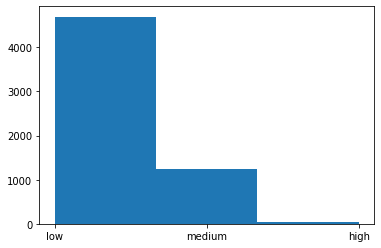

In [57]:
new_classifier = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=135, random_state=0))
new_classifier.fit(X_train, y_class_train)

y_pred_new = new_classifier.predict(X_test)
plt.hist(y_pred_1, bins=3);

In [58]:
print(classification_report(y_class_test, y_pred_new))

              precision    recall  f1-score   support

        high       0.14      0.02      0.03       258
         low       0.80      0.89      0.84      4238
      medium       0.52      0.44      0.48      1489

    accuracy                           0.74      5985
   macro avg       0.49      0.45      0.45      5985
weighted avg       0.70      0.74      0.72      5985



Very low F-score for high spenders. Let us try another model

#### Trying another ML model (SVM)

We shall now attempt use another ML model to see whether we can improve the accuracy

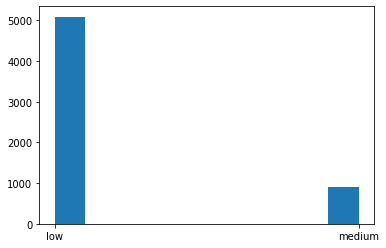

In [59]:
clf = make_pipeline(StandardScaler(), svm.SVC())
clf.fit(X_train, y_class_train)
y_pred_2 = clf.predict(X_test)
plt.hist(y_pred_2);

Accuracy score of the model is:  0.7537176274018379


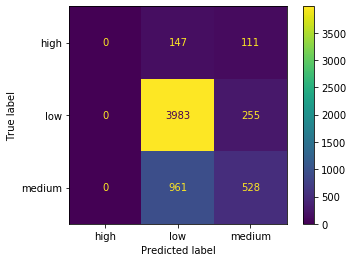

In [60]:
print ("Accuracy score of the model is: ", accuracy_score(y_class_test, y_pred_2))
plot_confusion_matrix(clf, X_test, y_class_test, values_format='d');

In [61]:
print(classification_report(y_class_test, y_pred_2))

              precision    recall  f1-score   support

        high       0.00      0.00      0.00       258
         low       0.78      0.94      0.85      4238
      medium       0.59      0.35      0.44      1489

    accuracy                           0.75      5985
   macro avg       0.46      0.43      0.43      5985
weighted avg       0.70      0.75      0.71      5985



/Users/zainfarrukh/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM do not predict any high spender. This is because classes are very imbalanced. Only 4.4% of the data is for high spenders only.

In [62]:
clean_df['spend_label'][clean_df['spend_label']=='high'].count()/clean_df['spend_label'].count()

0.04394686272871585

### Removing class imbalance

One way of reducing class imbalance is undersample the low and medium spenders (i.e. low, high and medium spenders's data is equal) so that total sample to be fed into the balance is balanced.

In [63]:
# Equal classes
high_spend = clean_df[clean_df['spend_label']=='high']
mid_spend = clean_df[clean_df['spend_label']=='medium'].sample(n=high_spend['age'].count(), random_state=42)
low_spend = clean_df[clean_df['spend_label']=='low'].sample(n=high_spend['age'].count(), random_state=42)
new_features = pd.concat([high_spend, mid_spend, low_spend])
new_features.head()

age                                id  became_member_on   income  amount  \
89    39  6d28f18e91324d358d69d1e4b01f1ace          20170919  60000.0  705.50   
92    18  716a961d2afb4c1d8307522a8cbb4f07          20160727  47000.0  275.61   
116   39  fe97aa22dd3e48c8b143116a8403dd52          20171217  67000.0  562.77   
153   38  1eed89c11cc749a4bb93d8cef032821d          20170709  74000.0  796.77   
183   30  c894971c9e414a358b84255199727636          20160903  54000.0  700.47   

     count  offers_rcv  avg_reward  offers_done  perc_comp  ...       date  F  \
89    12.0           4    5.666667            3   0.750000  ... 2017-09-19  1   
92    22.0           6    4.000000            5   0.833333  ... 2016-07-27  0   
116   11.0           5    2.000000            1   0.200000  ... 2017-12-17  1   
153    8.0           1    2.000000            1   1.000000  ... 2017-07-09  0   
183   20.0           6    4.200000            5   0.833333  ... 2016-09-03  0   

     M  O  2013  2014  2015  2016  2017  2018  
89   0  0     0     0     0     0     1     0  
92   1  0     0     0     0     1     0     0  
116  0  0     0     0     0     0     1     0  
153  1  0     0     0     0     0     1     0  
183  1  0     0     0     0     1     0     0  

[5 rows x 22 columns]

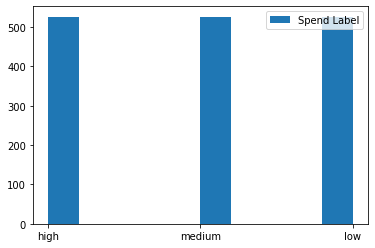

In [64]:
plt.hist(new_features['spend_label']);
plt.legend(['Spend Label']);

In [65]:
X_new = np.array(new_features.drop(['id', 'became_member_on', 'amount','count','spend_pctg', 'spend_label'
                           , 'date'], axis=1)) #Drop the irrelevant columns
y1_new = new_features['amount']
X_train, X_test, y1_train, y1_test = train_test_split(X_new, y1_new, test_size=0.50, random_state=42)
regr1 = make_pipeline(StandardScaler(), SVR(C=5.0, epsilon=0.1))
regr1.fit(X_train, y1_train)
y1_hat = regr1.predict(X_test)

In [66]:
print("Train R2-Score: {0}, Test R2-Score: {1}"
      .format(regr1.score(X_train, y1_train), regr1.score(X_test, y1_test)))

Train R2-Score: -0.023854173251558253, Test R2-Score: -0.05624945400851633


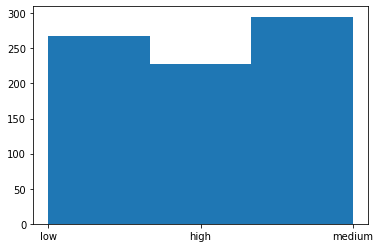

In [67]:
y_class_new = new_features['spend_label']

X_train, X_test, y_class_train, y_class_test = train_test_split(X_new, y_class_new, test_size=0.50, random_state=42)

classifier = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=30, random_state=0))
classifier.fit(X_train, y_class_train)

y_pred_1 = classifier.predict(X_test)
plt.hist(y_pred_1, bins=3);

Accuracy score of the model is:  0.49809885931558934


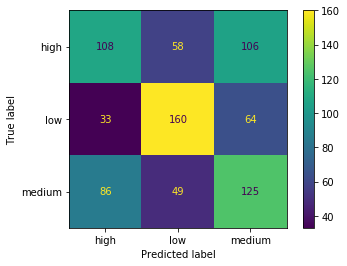

In [68]:
print ("Accuracy score of the model is: ", accuracy_score(y_class_test, y_pred_1))
plot_confusion_matrix(classifier, X_test, y_class_test, values_format="d");

In [69]:
print(classification_report(y_class_test, y_pred_1))

              precision    recall  f1-score   support

        high       0.48      0.40      0.43       272
         low       0.60      0.62      0.61       257
      medium       0.42      0.48      0.45       260

    accuracy                           0.50       789
   macro avg       0.50      0.50      0.50       789
weighted avg       0.50      0.50      0.50       789



Let us try it on SVC classifier

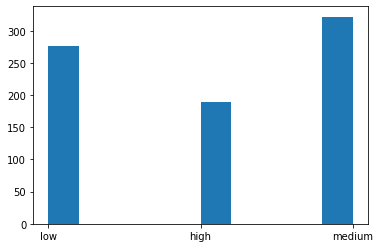

In [70]:
clf = make_pipeline(StandardScaler(), svm.SVC())
clf.fit(X_train, y_class_train)
y_pred_2 = clf.predict(X_test)
plt.hist(y_pred_2);

Accuracy score of the model is:  0.5120405576679341


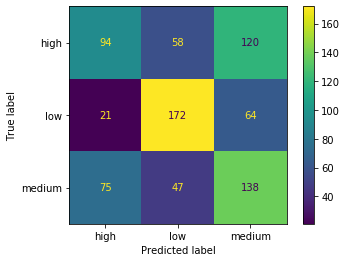

In [71]:
print ("Accuracy score of the model is: ", accuracy_score(y_class_test, y_pred_2))
plot_confusion_matrix(clf, X_test, y_class_test, values_format="d");

In [72]:
print(classification_report(y_class_test, y_pred_2))

              precision    recall  f1-score   support

        high       0.49      0.35      0.41       272
         low       0.62      0.67      0.64       257
      medium       0.43      0.53      0.47       260

    accuracy                           0.51       789
   macro avg       0.51      0.52      0.51       789
weighted avg       0.51      0.51      0.51       789



##### A great result so far! Lets try it to predict on our original dataset

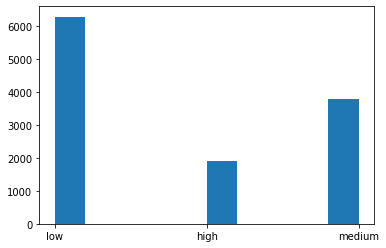

In [73]:
y_pred_3 = clf.predict(X)
plt.hist(y_pred_3);

Accuracy score of the RF model is:  0.612666053972763


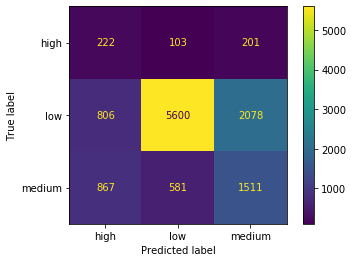

In [74]:
print ("Accuracy score of the RF model is: ", accuracy_score(y_class, y_pred_3)) #Accuracy on original dataset
plot_confusion_matrix(clf, X, y_class, values_format="d");

In [75]:
print(classification_report(y_class, y_pred_3))

              precision    recall  f1-score   support

        high       0.12      0.42      0.18       526
         low       0.89      0.66      0.76      8484
      medium       0.40      0.51      0.45      2959

    accuracy                           0.61     11969
   macro avg       0.47      0.53      0.46     11969
weighted avg       0.74      0.61      0.66     11969



Accuracy score of the SVC model is:  0.6024730553930988


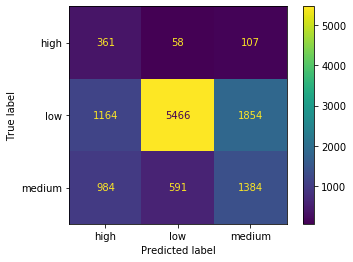

In [76]:
y_pred_4 = classifier.predict(X)
print ("Accuracy score of the SVC model is: ", accuracy_score(y_class, y_pred_4)) #Accuracy on original dataset
plot_confusion_matrix(classifier, X, y_class, values_format="d");

In [77]:
print(classification_report(y_class, y_pred_4))

              precision    recall  f1-score   support

        high       0.14      0.69      0.24       526
         low       0.89      0.64      0.75      8484
      medium       0.41      0.47      0.44      2959

    accuracy                           0.60     11969
   macro avg       0.48      0.60      0.48     11969
weighted avg       0.74      0.60      0.65     11969



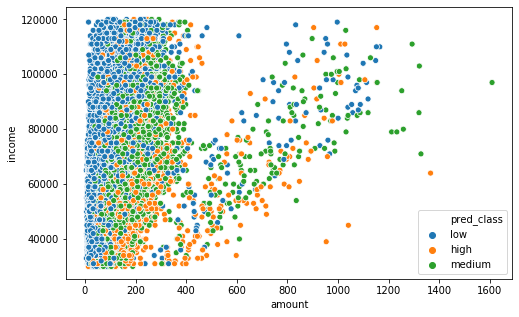

In [78]:
temp_df = clean_df.copy()
temp_df['pred_class'] = y_pred_3
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
sn.scatterplot(temp_df['amount'], temp_df['income'], hue=temp_df['pred_class']);

### Conclusion

ML regression model gives us key insights on likely purchase behaviour of the users as well. However, current features do not provide predictions which we can accurately rely on and we need to experiment with additional features to predict the actual amount of spend for each user. 

Current data can be used to classify each user based on their spend behaviour and we can use that classification to target each user with respect to number of offers and type of offers to be offered.

We were able to get 75% accuracy using SVM classifier to predict whether user was a high spender or low spender. Although model has a good accuracy score but model had very poor results for high spenders (indeterminate F1-score). Model could not even predict a single high spender. It was because labels were very imbalanced.

One of the way we can counter this class imbalance is to undersample data from classes with higher frequencies. I have selected random samples from low and medium spenders so that total number of sample from each class is same and trained my models on those data and predicted the whole dataset from that trained model. Although my accuracy score reduced to 60.24%-61.26% but I got much better F1-scores in high spender class. 

Based on on this information we can decide to which user we should offer the coupon offers. Coupon offers should be function of type of spender each user is i.e. users with high spend behaviour should get more coupon offers as they are more likely to make a purchase as well as relative difficulty of each coupon i.e. high spenders should be given coupon with greater difficulty.

### Next Steps

There is still much left to do to extract insights on user behaviour. We could do following additional activities to get more insights on the data:

1) Identify reason for anamolies in the data i.e. why people have more than 110 years age

2) Additional Features to improve accuracy of regression models

3) Get more samples so that we have sufficient set of high spenders

4) Test relationships between each type of offer and various classes of users.

5) Identify suitable clusterrings of users

6) Use Grid Search to check whether there is any better models with better hyper parameters

7) Use more granular search to find additional models which fit better on our data
